In [19]:
import glob
import itertools

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

from invisible_cities.database.load_db                 import DataSiPM
from invisible_cities.sierpe  .blr                     import deconv_pmt
from invisible_cities.reco    .peak_functions          import rebin_times_and_waveforms
from invisible_cities.reco    .calib_sensors_functions import calibrate_wfs
from invisible_cities.reco    .calib_sensors_functions import calibrate_sipms
from invisible_cities.icaro   .hst_functions           import labels
from invisible_cities.database.load_db                 import DataPMT
from invisible_cities.database.load_db                 import DataSiPM

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

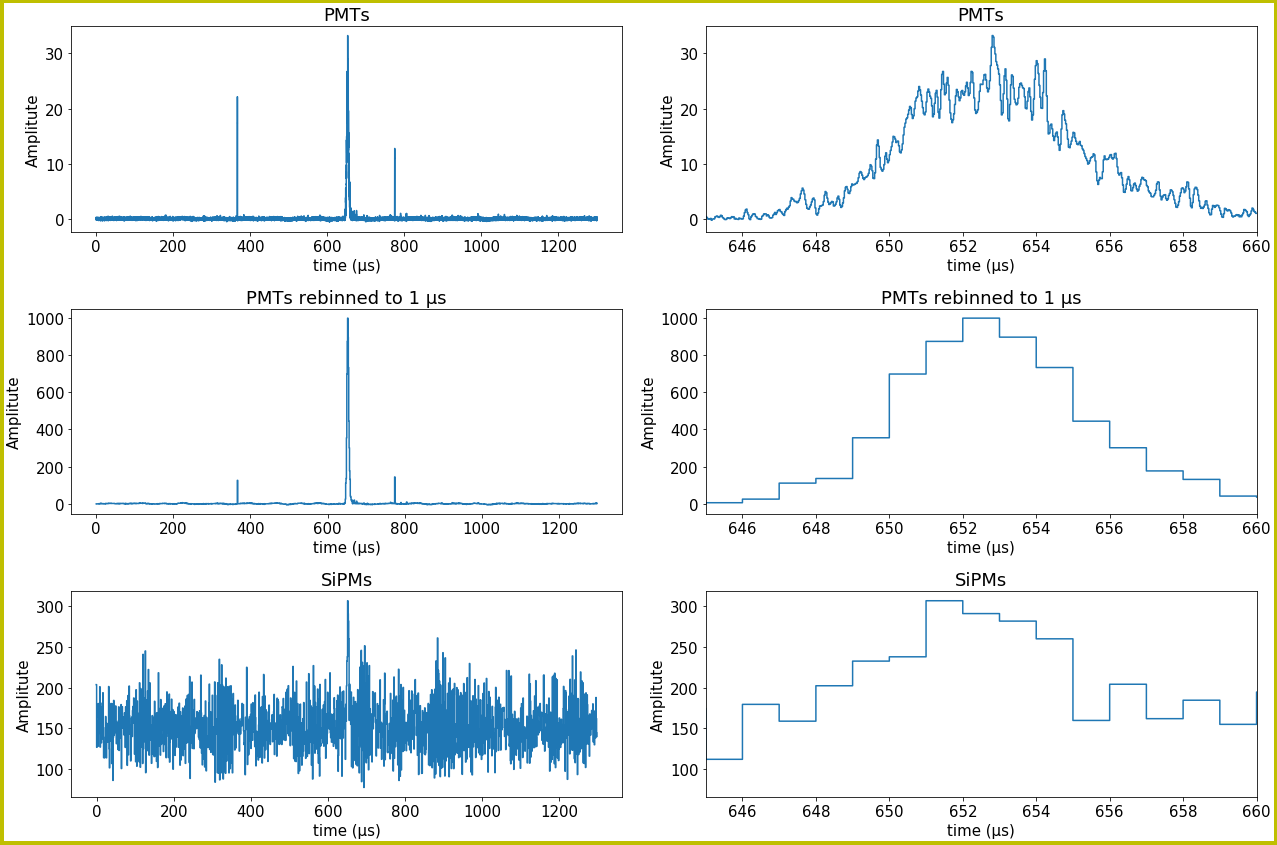

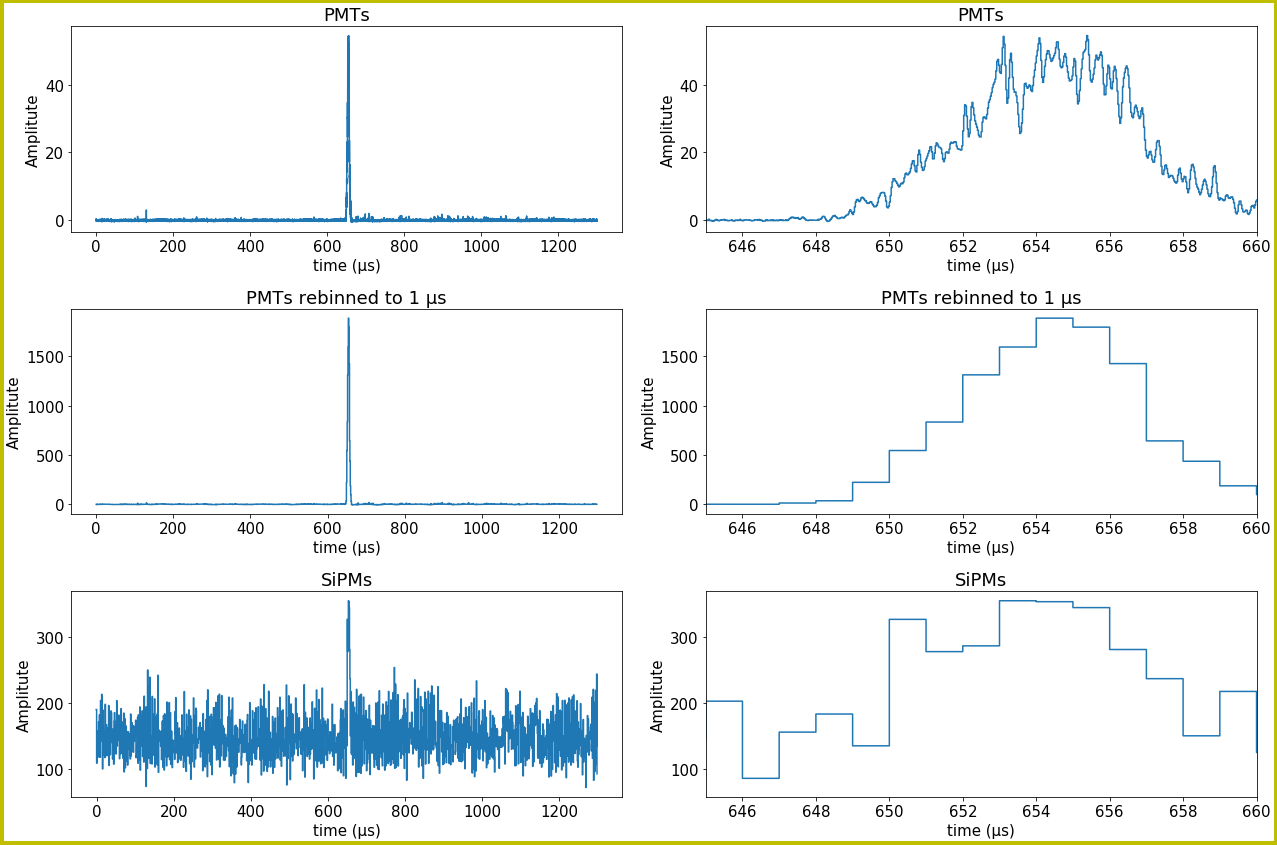

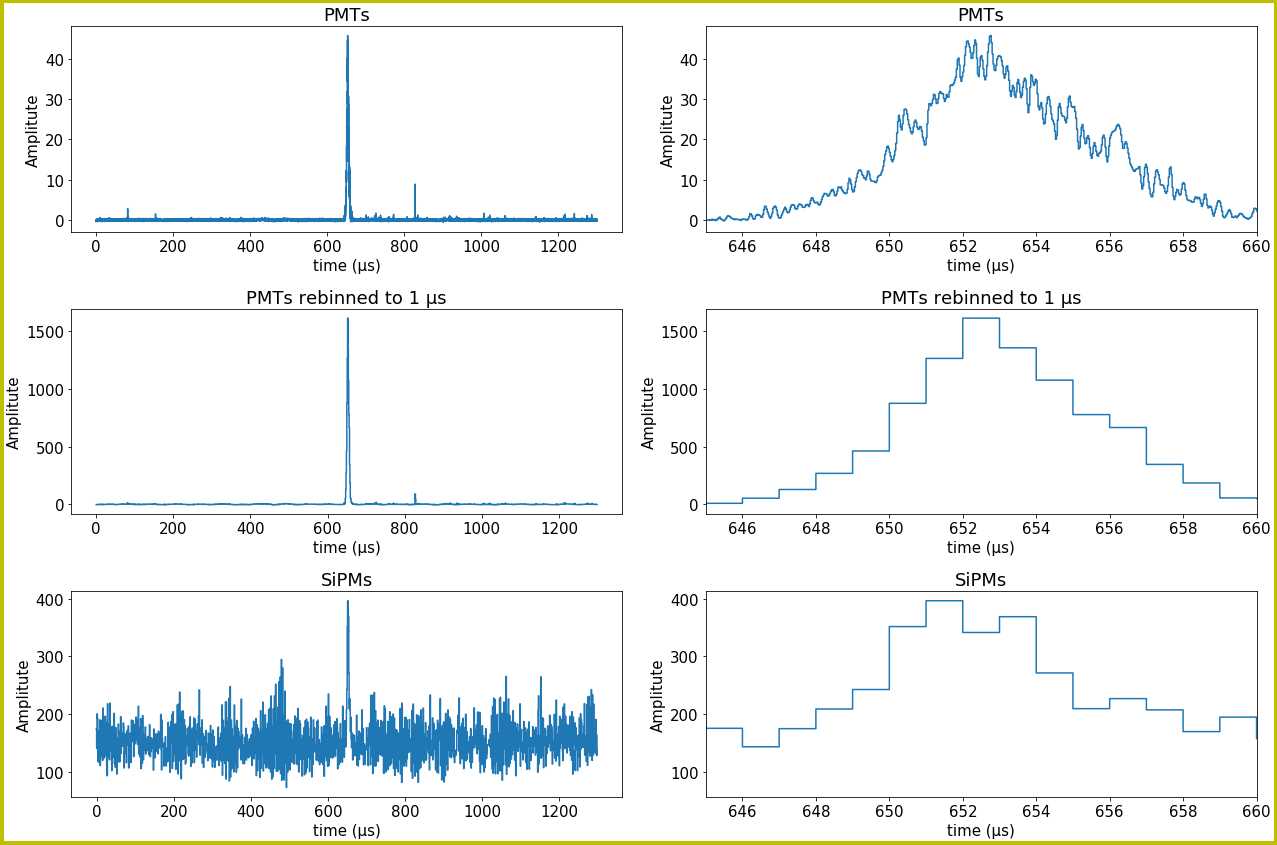

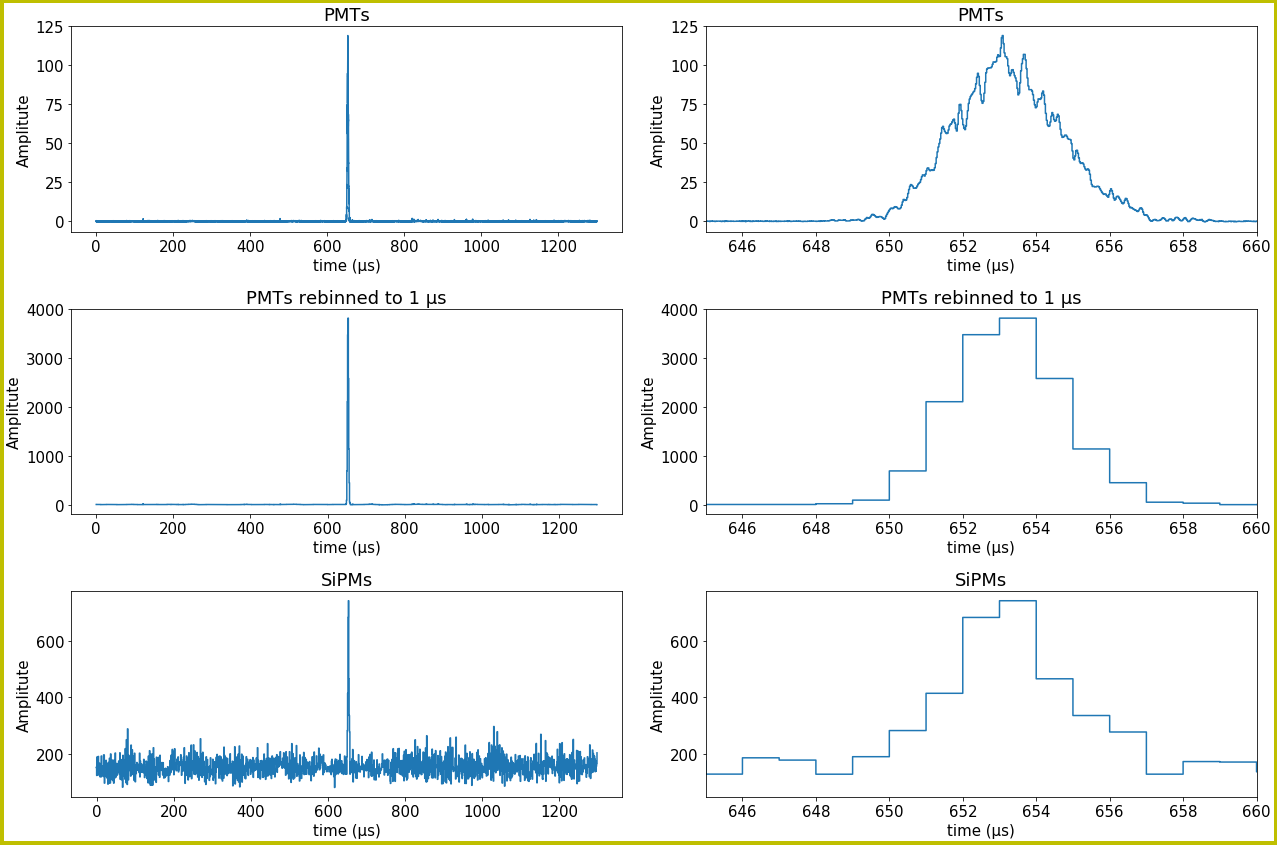

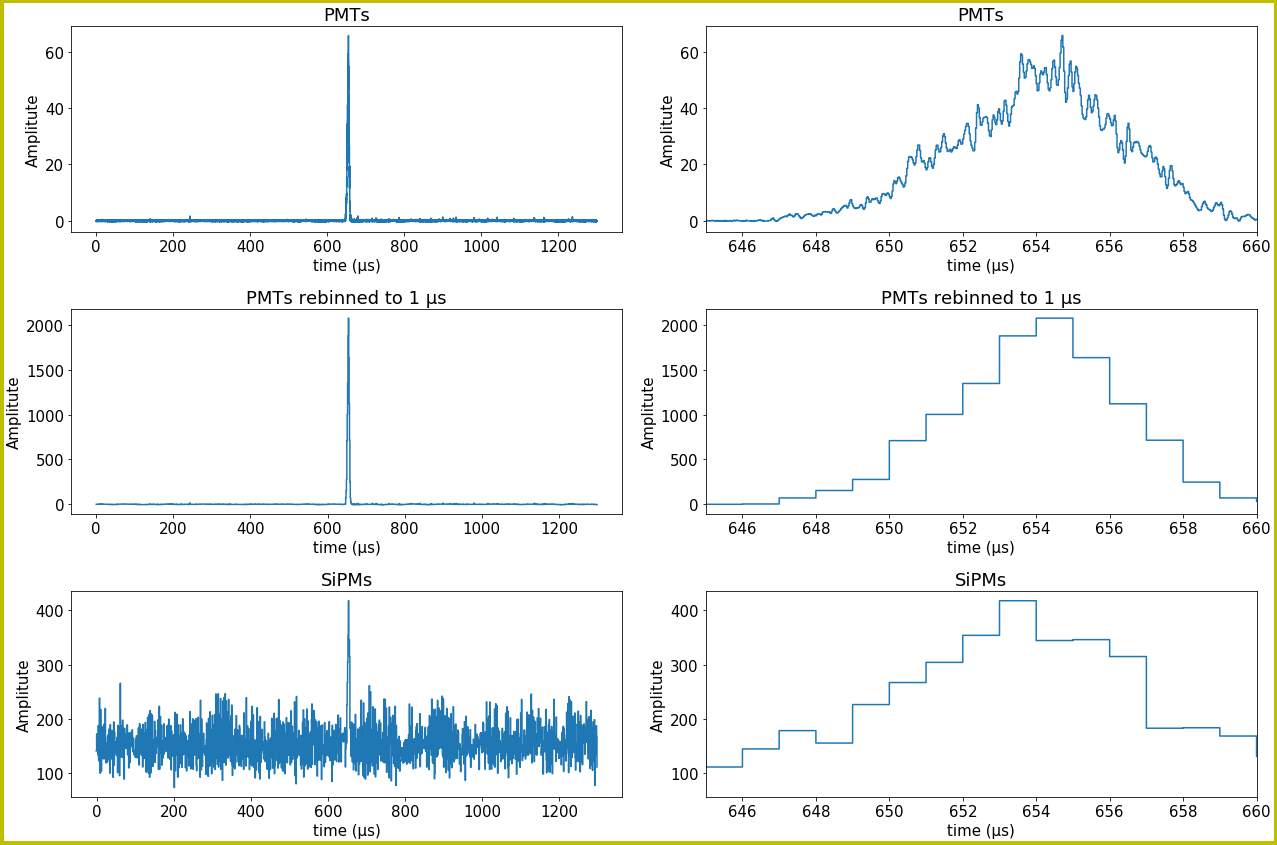

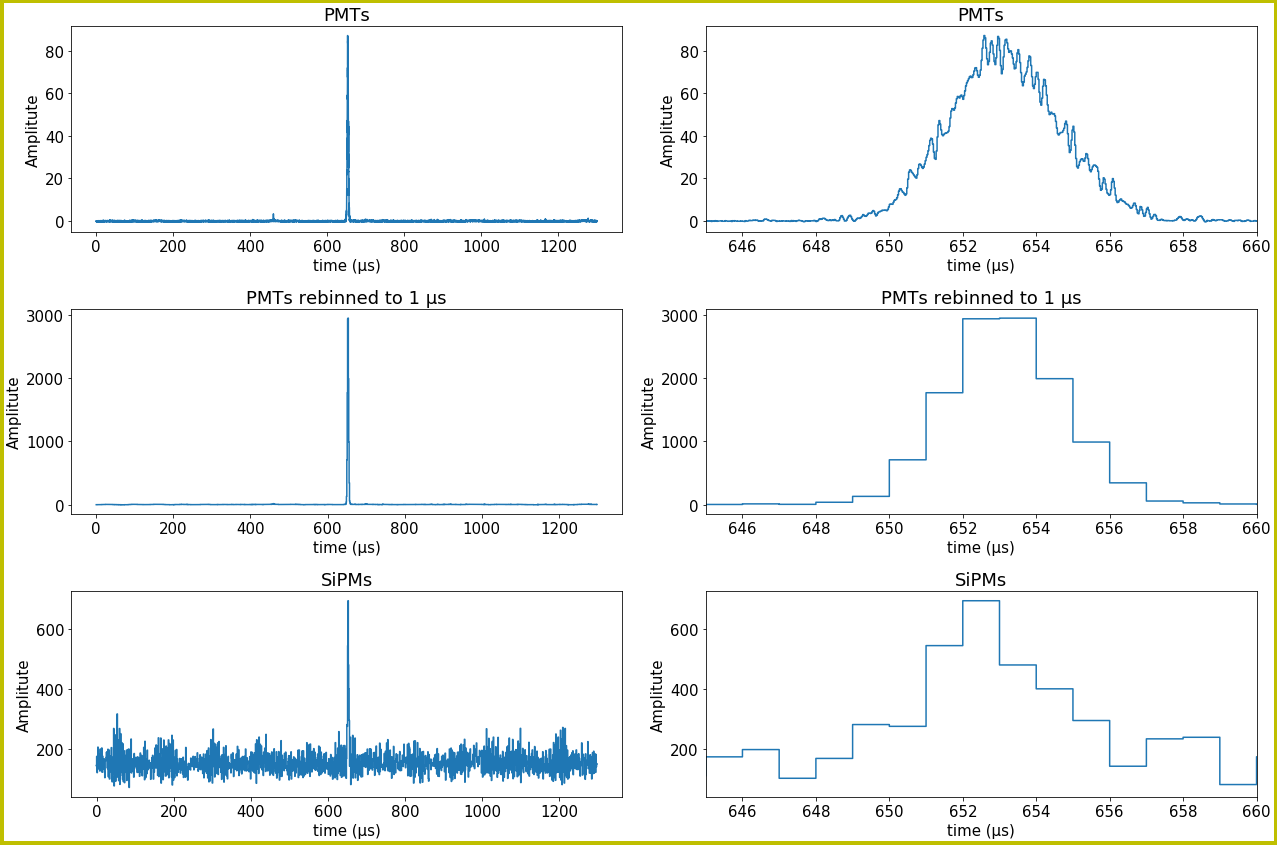

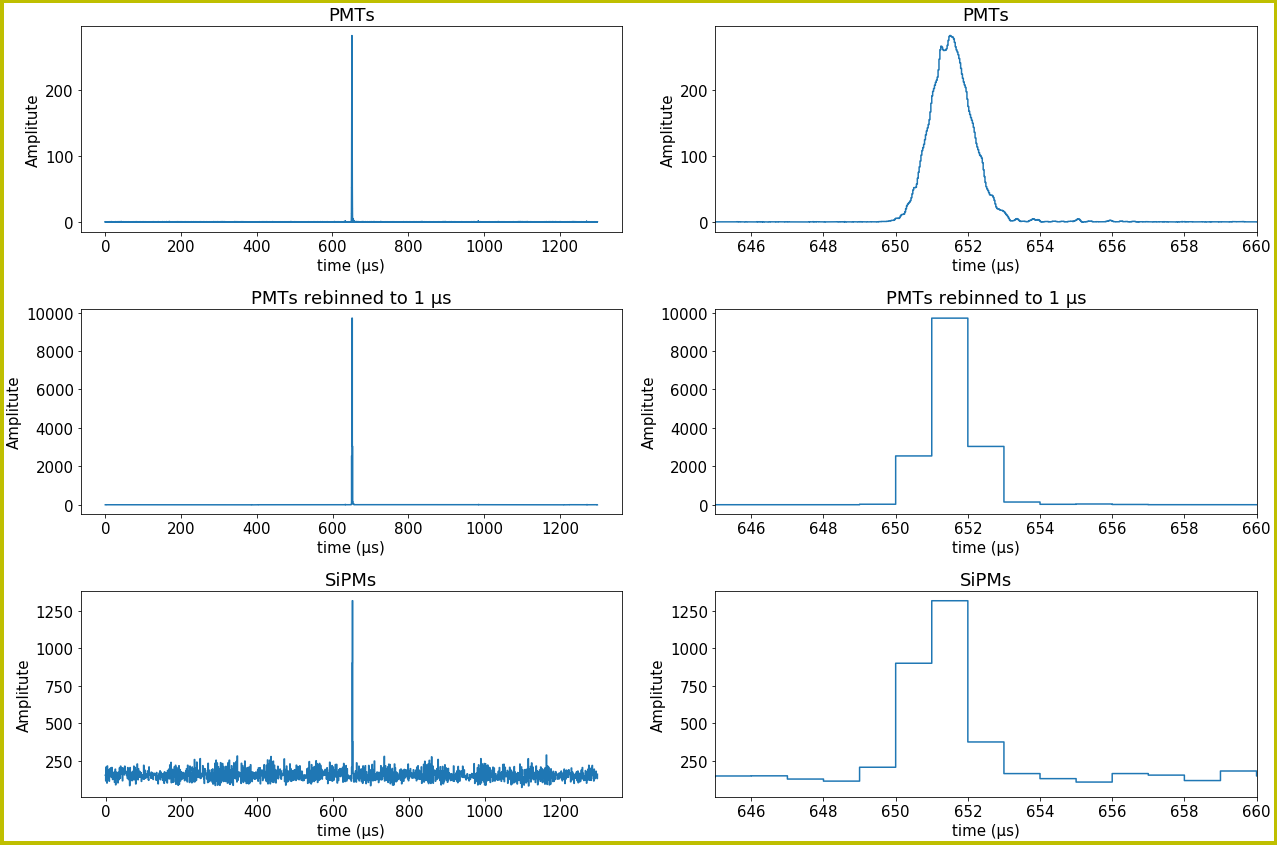

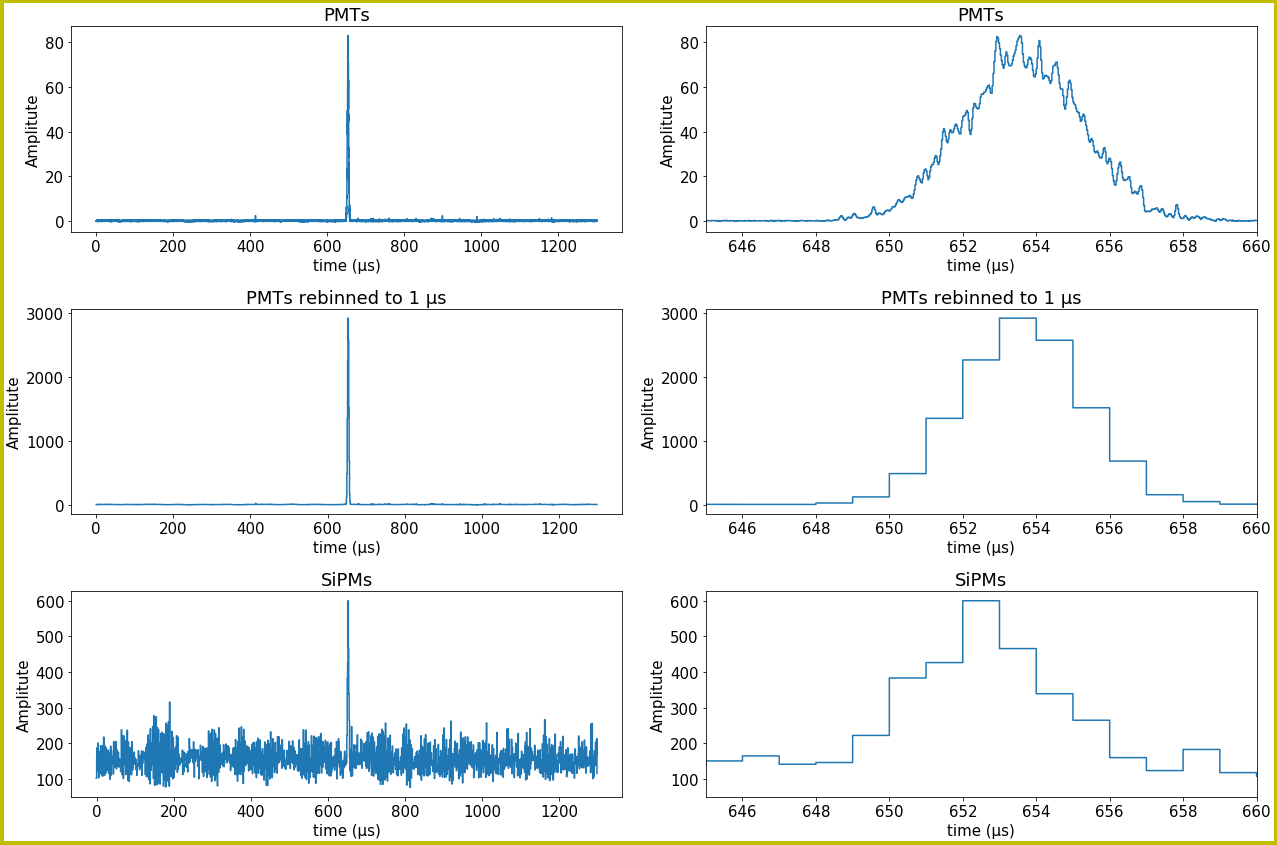

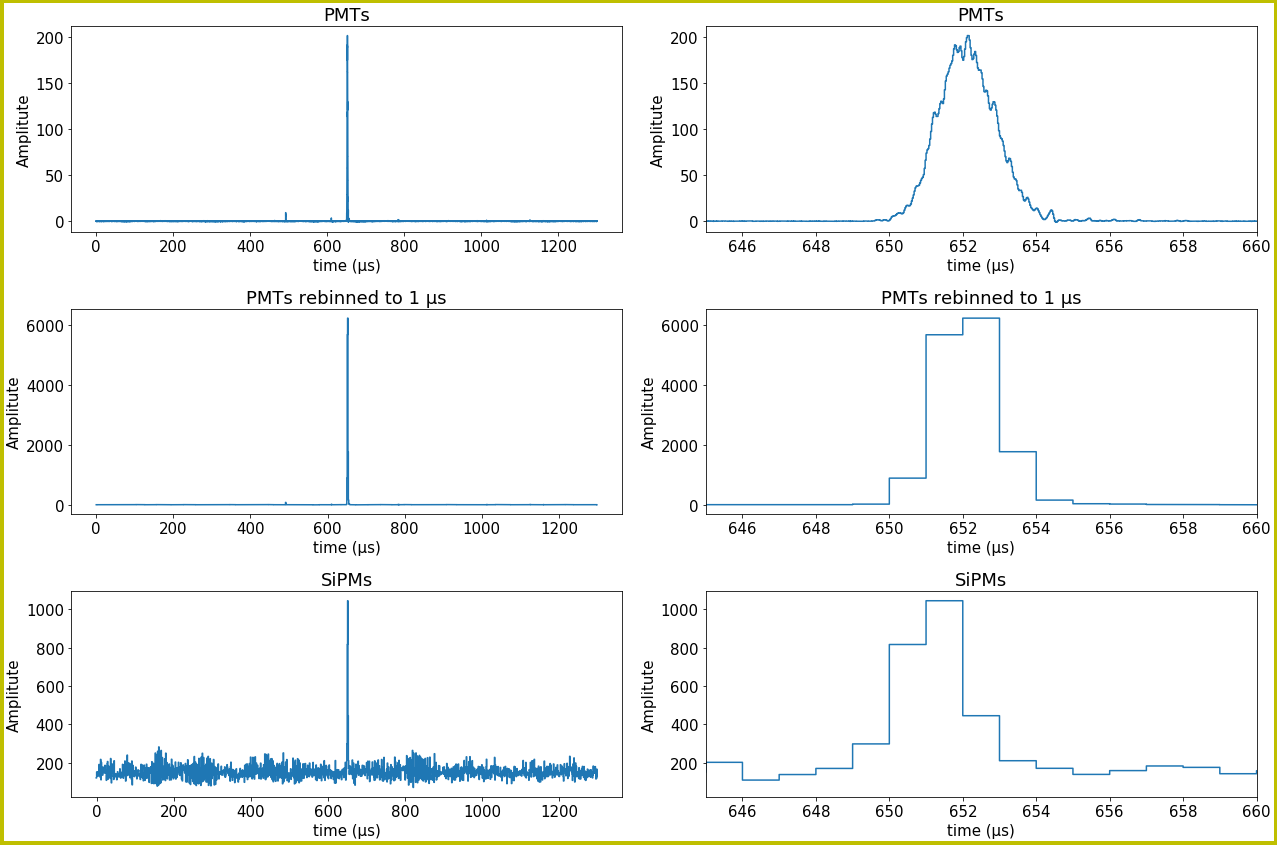

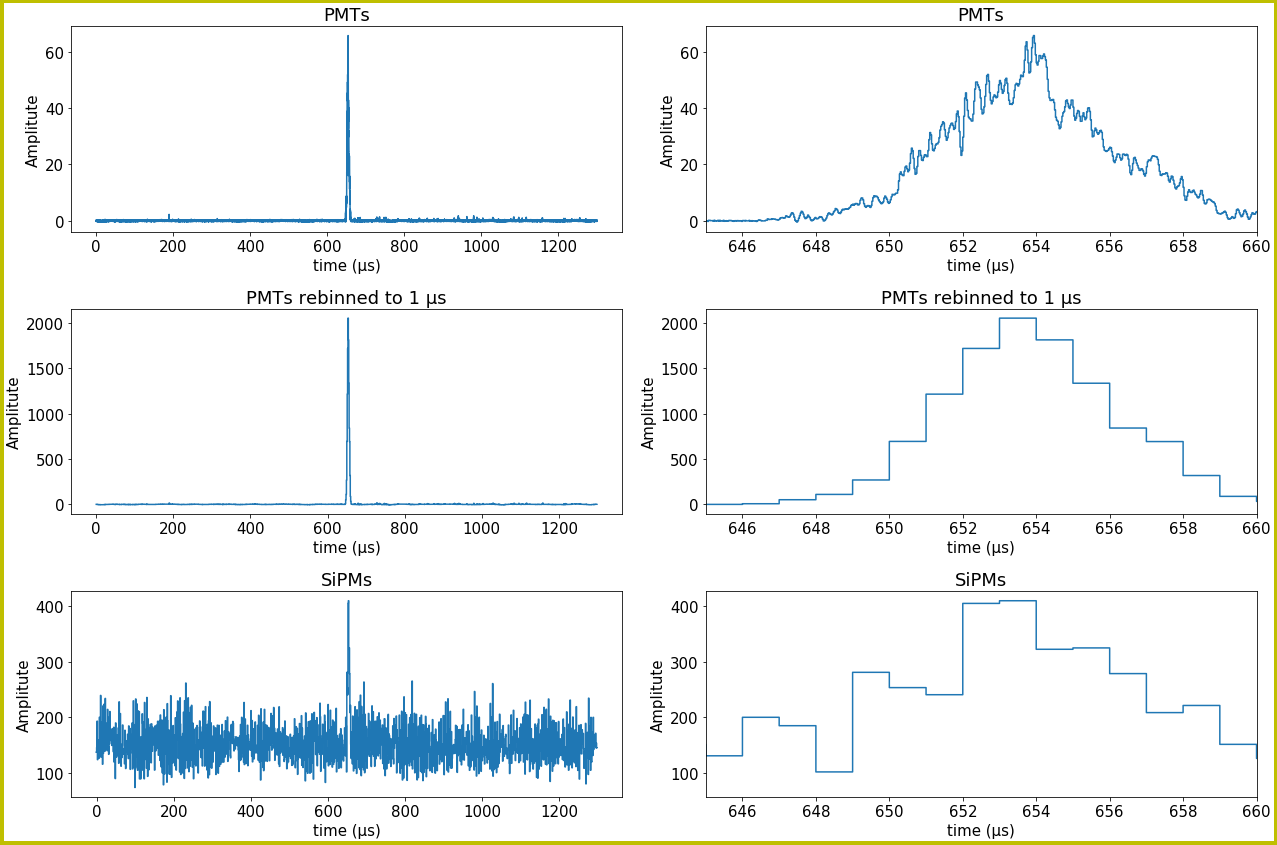

In [26]:
run_number     = 5434
first_event    =    0
n_events       =   10
file_number    =    0
input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/rwf/run_{run_number}_{file_number:04}_waveforms.h5"
#input_filename = f"/Users/Gonzalo/github/NEXTdata/Kr/{run_number}/rwf/dst_waves.gdcsnext.000_{run_number}.root.h5"
datapmt        = DataPMT (run_number)
datasipm       = DataSiPM(run_number)

with tb.open_file(input_filename) as file:
    all_pmt_wfs  = file.root.RD.pmtrwf
    all_sipm_wfs = file.root.RD.sipmrwf
    pmt_times    = np.arange(all_pmt_wfs.shape [2]) / 40
    sipm_times   = np.arange(all_sipm_wfs.shape[2]) - 1
    for i in range(first_event, first_event + n_events):
        pmt_wfs  = deconv_pmt(all_pmt_wfs[i],
                              coeff_c    = datapmt.coeff_c.values,
                              coeff_blr  = datapmt.coeff_blr.values,
                              n_baseline = 48000)
        pmt_wfs  = calibrate_wfs(pmt_wfs, datapmt.adc_to_pes.values)
        pmt_wf   = np.sum(pmt_wfs, axis=0)

        sipm_wfs = calibrate_sipms(all_sipm_wfs[i], datasipm.adc_to_pes.values, 0)
        sipm_wf  = np.sum(sipm_wfs, axis=0)

#        pmt_times_, (pmt_wf_,) = rebin_times_and_waveforms(pmt_times, pmt_wf[np.newaxis], 40)
        pmt_times_ = sipm_times + 1
        pmt_wf_    = pmt_wf.reshape(pmt_wf.size // 40, 40).sum(axis=1)

        max_ = np.argmax(pmt_wf_)
        min_, max_ = max_ - 10, max_ + 10
        min_, max_ = 645, 660
#        min_, max_ = 0, 5
        plt.figure(figsize=(18, 12), edgecolor="y", linewidth=8)
        draw_opts = dict(drawstyle="steps-post")
#        draw_opts = dict(marker="p", linestyle="None")
    
        plt.subplot(3, 2, 1)
        plt.plot( pmt_times,  pmt_wf, **draw_opts)
        labels("time (µs)", "Amplitute", "PMTs")

        plt.subplot(3, 2, 2)
        plt.plot( pmt_times,  pmt_wf, **draw_opts)
        plt.xlim(min_, max_)
        labels("time (µs)", "Amplitute", "PMTs")

        plt.subplot(3, 2, 3)
        plt.plot( pmt_times_,  pmt_wf_, **draw_opts)
        labels("time (µs)", "Amplitute", "PMTs rebinned to 1 µs")

        plt.subplot(3, 2, 4)
        plt.plot( pmt_times_,  pmt_wf_, **draw_opts)
        plt.xlim(min_, max_)
        labels("time (µs)", "Amplitute", "PMTs rebinned to 1 µs")

        plt.subplot(3, 2, 5)
        plt.plot(sipm_times, sipm_wf, **draw_opts)
        labels("time (µs)", "Amplitute", "SiPMs")

        plt.subplot(3, 2, 6)
        plt.plot(sipm_times, sipm_wf, **draw_opts)
        plt.xlim(min_, max_)
        labels("time (µs)", "Amplitute", "SiPMs")
        #print(sipm_wf[min_: max_])
        plt.tight_layout()

In [27]:
run_number      = 5434
input_filenames = glob.glob(f"/Users/Gonzalo/github/NEXTdata/runiii/rwf/run_{run_number}_*_waveforms.h5")
#run_number      = 4446
#input_filenames = glob.glob(f"/Users/Gonzalo/github/NEXTdata/Kr/4446/rwf/dst_waves.gdcsnext.*_4446.root.h5")
datapmt         = DataPMT (run_number)
datasipm        = DataSiPM(run_number)

sipms  = []
deltas = []

for input_filename in input_filenames:
    with tb.open_file(input_filename) as file:
        all_pmt_wfs  = file.root.RD.pmtrwf
        all_sipm_wfs = file.root.RD.sipmrwf
        pmt_times    = np.arange(all_pmt_wfs.shape [2]) / 40
        sipm_times   = np.arange(all_sipm_wfs.shape[2])
        for i in range(all_pmt_wfs.shape[0]):
            pmt_wfs   = deconv_pmt(all_pmt_wfs[i],
                                   coeff_c    = datapmt.coeff_c.values,
                                   coeff_blr  = datapmt.coeff_blr.values,
                                   n_baseline = 48000)
            pmt_wfs   = calibrate_wfs(pmt_wfs, datapmt.adc_to_pes.values)
            pmt_wf    = np.sum(pmt_wfs, axis=0)
            pmt_t_max = pmt_times[np.argmax(pmt_wf)]

            sipm_wfs     = calibrate_sipms(all_sipm_wfs[i], datasipm.adc_to_pes.values, 0)
            (sipm_max,
             sipm_t_max) = np.unravel_index(np.argmax(sipm_wfs), sipm_wfs.shape)

            sipms .append(sipm_max)
            deltas.append(pmt_t_max - sipm_t_max)


s      = np.argsort(sipms)
sipms  = np.array  (sipms)
deltas = np.array  (deltas)
shifts = pd.DataFrame(dict(sipm_id = sipms                  [s],
                           delta   = deltas                 [s],
                           x       = datasipm.X.values[sipms[s]],
                           y       = datasipm.Y.values[sipms[s]]))

In [28]:
len(shifts.groupby("sipm_id"))

48

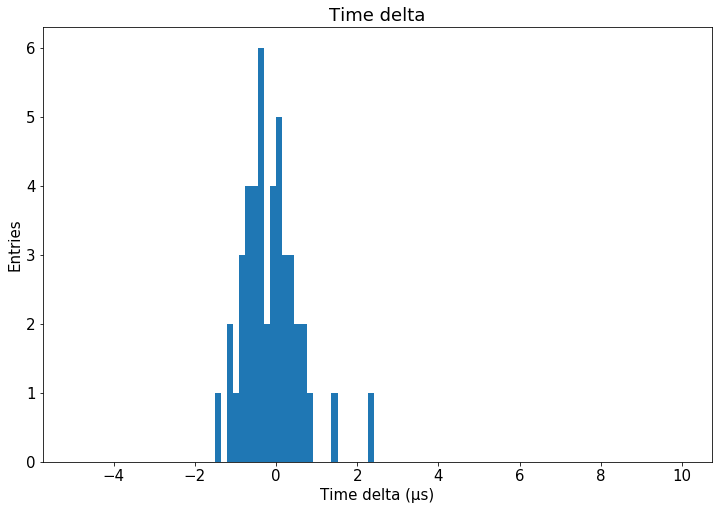

In [29]:
plt.hist(shifts.delta, np.linspace(-5, 10, 100))
labels("Time delta (µs)", "Entries", "Time delta")

In [30]:
shifts.delta[(shifts.delta > -2) & (shifts.delta < 4)].std()

0.70231938977400166

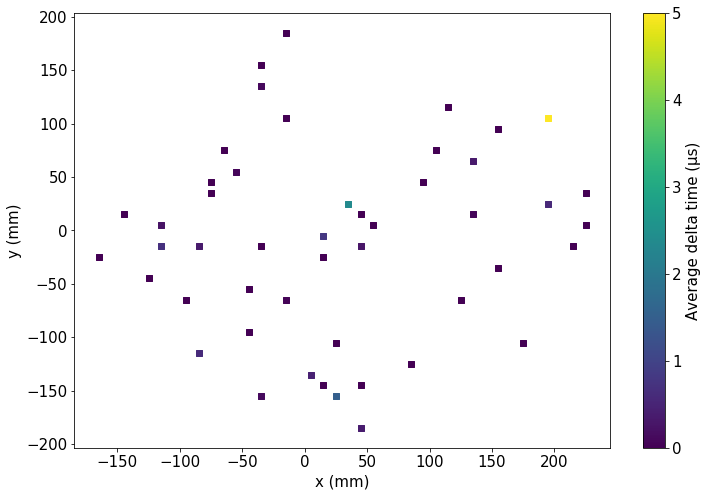

In [31]:
gb = shifts.groupby("sipm_id")

plt.scatter(gb.x.mean().values,
            gb.y.mean().values,
            c      = gb.delta.mean(),
            marker = "s",
            vmin   =   0,
            vmax   =   5)
plt.colorbar().set_label("Average delta time (µs)")
labels("x (mm)", "y (mm)")

In [ ]:
run_number = 5091

from invisible_cities.core.core_functions import weighted_mean_and_std

input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/rwf/run_{run_number}_0010_waveforms.h5"

with tb.open_file(input_filename) as file:
    for wfs in file.root.RD.pmtblr:
        wfs = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
        plt.figure(figsize=(18, 15))
        for i, wf in enumerate(wfs, start=1):
            plt.subplot(4, 3, i)
            lims = 25000, 27000
            slic = slice(*lims)
            where = np.zeros(wf.size, dtype=bool)
            where[slic] = True
            where = where & (wf > 200)
            t   = np.arange(wf.size) * 25 / 1e3
            plt.plot(t[where], wf[where])
#            plt.xlim(*lims)
            try:
                rms = weighted_mean_and_std(t[where], wf[where])
                print(i, *rms)
            except:
                pass
        plt.show()
        input()

In [ ]:
input_filename = "/Users/Gonzalo/github/NEXTdata/runiii/run_5025_0000_waveforms.h5"
with tb.open_file(input_filename) as file:
    for wfs in file.root.RD.pmtrwf:
        wfs    = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
        sum_wf = np.sum (wfs, axis=0)
        
        print(np.sum(sum_wf[sum_wf > 5]))
        print(sum(1 for wf in wfs if wf[wf > 5].sum() > 10))
        max = np.argmax(wf)
        where = slice(max - 100, max + 100)
        plt.plot(wf[where])
#        plt.show()
        input()

In [ ]:
input_filename = "/Users/Gonzalo/github/NEXTdata/runiii/run_5025_0000_waveforms.h5"
with tb.open_file(input_filename) as file:
    for wfs in file.root.RD.pmtrwf:
        wfs    = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
        plt.plot(wfs.T)
        plt.show()
        input()

In [ ]:
input_filename = "/Users/Gonzalo/github/NEXTdata/runiii/run_5025_0000_waveforms.h5"

with tb.open_file(input_filename) as file:
    n = []

    for wfs in file.root.RD.pmtrwf:
        wfs  = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
        n   += np.any(np.where(wfs > 5, True, False), axis=1)
        n.extend([i for i, wf in wfs if np.any(wf > 5)])

plt.plot(np.arange(12), n)

In [ ]:
run_number = 5054
input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/run_{run_number}_0000_waveforms.h5"

with tb.open_file(input_filename) as file:
    n = []

    for wfs in file.root.RD.pmtrwf:
        wfs  = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
#        n   += np.any(np.where(wfs > 5, True, False), axis=1)
        n.extend([i for i, wf in enumerate(wfs) if np.any(wf > 5)])

plt.hist(n, bins=np.arange(13))
plt.xlabel("PMT #")
plt.ylabel("# events")
plt.savefig(f"/Users/Gonzalo/Desktop/pmt_touched_{run_number}.pdf")

In [ ]:
run_number = 5054

input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/run_{run_number}_0000_waveforms.h5"
energies = []
with tb.open_file(input_filename) as file:
    for wfs in file.root.RD.pmtrwf:
        wfs    = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
        sum_wf = np.sum (wfs, axis=0)
        energy = sum_wf[sum_wf > 5].sum()
        energies.append(energy)
y, x , _= plt.hist(energies, bins=np.linspace(0, 1e6, 100))
plt.xlabel("Energy (adc)")
plt.ylabel("Entries")
plt.savefig(f"Energy_{run_number}.pdf")

In [ ]:
x = x[:-1]
sel = x < 750e3
np.average(x[sel], weights=y[sel])

In [ ]:
run_number = 5054
import glob
input_filenames = glob.glob(f"/Users/Gonzalo/github/NEXTdata/runiii/run_{run_number}_*_waveforms.h5")

for input_filename in input_filenames:
    n = [[] for i in range(12)]
    try:
        with tb.open_file(input_filename) as file:
            for wfs in file.root.RD.pmtrwf:
                wfs  = np.mean(wfs, axis=1)[:, np.newaxis] - wfs
                for i, wf in enumerate(wfs):
                    n[i].append(int(np.any(wf > 5)))
    except:
        continue

n = np.array(n)
plt.plot(n.T)
plt.xlabel("Time (a.u.)")
#plt.savefig(f"/Users/Gonzalo/Desktop/pmt_touched_{run_number}.pdf")

In [ ]:
run_number = 5054
old_input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/old/run_{run_number}_0000_waveforms.h5"
new_input_filename = f"/Users/Gonzalo/github/NEXTdata/runiii/run_{run_number}_0000_waveforms.h5"

from invisible_cities.database.load_db import DataPMT
datapmt   = DataPMT(run_number)
old_order = np.argsort(datapmt.ChannelID.values)
print(old_order)
with tb.open_file(old_input_filename) as old_file, tb.open_file(new_input_filename) as new_file:
    for old_wfs, new_wfs in zip(old_file.root.RD.pmtblr, new_file.root.RD.pmtblr):
        for i in range(12):
            j = old_order[i]
            old_wf = old_wfs[i]
            new_wf = new_wfs[j]
            plt.plot(old_wf, "r-")
            plt.plot(new_wf, "k-")
            plt.show()
            input()